In [88]:
import zipfile
import pandas as pd
import movie_utils
from tqdm import tqdm, trange
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# data from: https://grouplens.org/datasets/movielens/

files = {}

with zipfile.ZipFile("ml-32m.zip", 'r') as zip:
    zip_contents = zip.namelist()
    for file_name in zip_contents:
        if file_name.endswith('.csv'):
            print("Downloading " + file_name + "...")
            with zip.open(file_name) as file:
                df = pd.read_csv(file)
                files[file_name[7:-4]] = df

In [42]:
files["links"] = files["links"][["movieId", "tmdbId"]]
files["links"].head()

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [43]:
files["ratings"] = files["ratings"][["userId", "movieId", "rating"]]
files["ratings"].head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0


In [44]:
files["movies"] = files["movies"].merge(files["links"], left_on="movieId", right_on="movieId", how="inner")
files["movies"].head()

,movieId,title,genres,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357.0
4,5,Father of the Bride Part II (1995),Comedy,11862.0


In [45]:
movies = {}

for movie in files["movies"].iterrows():
    movie = movie[1]
    movies[movie.movieId] = movie_utils.Movie(movie.movieId, movie.tmdbId, movie.title, movie.genres)

In [46]:
user = files["ratings"][files["ratings"]["userId"] == 2024][:5]
for movie in user.iterrows():
    if movie[1].movieId in movies.keys():
        print("-----------------------------------------------------------------------------------------------")
        print(movies[movie[1].movieId])
        print("Rating: " + str(movie[1].rating))

-----------------------------------------------------------------------------------------------
Clerks 	1994
Comedy
Rating: 1.0
-----------------------------------------------------------------------------------------------
Exotica 	1994
Drama
Rating: 2.0
-----------------------------------------------------------------------------------------------
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) 	1994
Drama
Rating: 1.0
-----------------------------------------------------------------------------------------------
Maltese Falcon, The 	1941
Film-Noir | Mystery
Rating: 5.0
-----------------------------------------------------------------------------------------------
Gone with the Wind 	1939
Drama | Romance | War
Rating: 5.0


In [ ]:
popular_movies = files["ratings"][["movieId", "userId"]].groupby("movieId").count()
popular_movies = popular_movies.sort_values(by=["userId"], ascending=False)
popular_movies = popular_movies.index.values.tolist()

num_movies = 1000
top_popular_movies = set(popular_movies[:num_movies])

In [ ]:
total = len(files["ratings"])
ratings = np.empty((total, 3), dtype=np.float32)

i = 0
for rating in tqdm(files["ratings"].iterrows(), total=total):
    if rating[1].movieId in top_popular_movies:
        ratings[i, 0] = rating[1].userId
        ratings[i, 1] = rating[1].movieId
        ratings[i, 2] = rating[1].rating
        i += 1

ratings = ratings[:i]
np.savez_compressed("ratings.npz", ratings=ratings)

100%|██████████| 32000204/32000204 [31:23<00:00, 16992.68it/s]


In [3]:
ratings = np.load("ratings.npz")["ratings"]

In [4]:
ratings_df = pd.DataFrame(ratings, columns=["userId", "movieId", "rating"], index=[i for i in range(len(ratings))])
ratings_df["userId"] = ratings_df["userId"].astype(int)
ratings_df["movieId"] = ratings_df["movieId"].astype(int)
ratings_df.head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,32,5.0
4,1,34,2.0


In [49]:
ratings_df = ratings_df.pivot_table(index="userId", columns="movieId", values="rating")
ratings_df

KeyError: 'rating'

In [103]:
def isvt(X, r, max_iter=500, epsilon=1e-3):
    # Create a mask for the known entries in X
    mask = X > 0  
    prevM = np.zeros(X.shape)
    prevM[mask] = X[mask]

    progress_bar = trange(max_iter)
    
    for _ in progress_bar:
        currM = np.copy(prevM)
        
        # Perform Singular Value Decomposition
        U, S, Vt = svds(currM, k=r) # Threshold by only calculating the top r singular values
        currM = U @ np.diag(S) @ Vt

        # Fill in known values in currM from X
        currM[mask] = X[mask]
        
        # Check for convergence
        norm = np.linalg.norm(currM - prevM, ord='fro') / np.linalg.norm(prevM, ord='fro')
        if norm < epsilon:
            break
            
        progress_bar.set_description(f"[{r=:}, {norm=:.3e}]")
        
        prevM = currM
    
    return currM

In [38]:
num_users = 20000
M = isvt(ratings_df[:num_users].to_numpy(), r=50, epsilon=1e-2)

[norm=1.001e-03]:  12%|█▏        | 241/2000 [05:59<43:40,  1.49s/it]


In [40]:
M_df = pd.DataFrame(M, columns=ratings_df.columns, index=ratings_df.index[:num_users])
M_df

movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
1,6.666603,1.006412,-3.380958,-1.511201,4.870695,-0.786424,2.552277,0.738848,1.398883,4.000000,...,3.039157,1.458093,1.632800,2.744962,-1.571040,-1.284736,-0.378253,2.662261,2.852563,0.832819
2,6.210655,3.518688,3.938739,5.374224,0.103207,3.227388,3.516873,4.597174,0.649753,2.805076,...,-0.243530,-0.740807,-1.959932,-1.633634,-1.062328,-1.945836,-0.467280,-2.064324,-1.919746,-1.220403
3,3.547590,3.500000,2.582665,2.694170,2.405317,4.584936,4.000000,4.000000,1.507398,5.000000,...,-0.465559,-0.433715,0.640776,0.015236,0.644797,0.321420,0.013036,-0.958841,-0.183344,-0.198052
4,-0.738699,-0.709277,0.643658,-1.287223,-0.360235,-0.570521,1.654106,2.661747,0.794590,-0.745831,...,-0.832440,-0.201089,0.487127,-0.244253,0.610077,-0.225484,-0.546367,-0.588483,-1.179420,0.073835
5,3.295296,3.614891,0.299849,0.742873,0.839087,0.468620,4.000000,1.756623,-0.117136,-1.311481,...,1.196671,0.297026,0.225851,0.565350,0.605104,0.956653,0.024372,1.311374,1.954708,0.953970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,1.556037,1.064656,0.465916,-0.055680,-0.034042,-1.705790,-1.085247,-2.306889,0.140107,-0.768879,...,2.940083,1.779874,0.942334,0.620102,3.801264,3.442159,2.928025,1.738581,2.408099,1.882085
20002,2.806586,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,...,-0.063585,-0.119757,0.135178,-0.290559,-0.063488,0.226594,-0.311541,-0.252997,-0.343309,0.099981
20003,1.942123,2.059370,4.097816,4.058199,5.004349,4.727534,1.439923,4.385109,3.961152,3.526898,...,-1.489840,-1.122845,-2.514016,-2.070602,-1.584784,1.304831,-1.429472,-3.467573,-1.930502,-2.089612


In [112]:
def eval_matrix_completion(X, r, test_proportion=0.1):
    '''
    take out n% of values from matrix
    perform isvt 
    compare and see if predicted values are close to original ones
    '''
    return (r-200)**2

def cross_val_isvt(X, r_list=[2**n for n in range(1,10)], plot=True):
    scores = [] 

    for r in r_list:
        scores.append(eval_matrix_completion(X, r))
    
    if plot:
        plt.plot(r_list, scores)

    best = np.argmin(np.array(scores))
    return r_list[best]

In [71]:
df = ratings_df[:num_users]
ratings_per_user = df.T.count()
ratings_per_user
test_proportion = 0.1
(ratings_per_user * test_proportion // 1).astype(int)

userId
1         8
2         4
3        12
4         1
5         3
         ..
20001     2
20002    10
20003     3
20004     7
20005     1
Length: 20000, dtype: int64

256

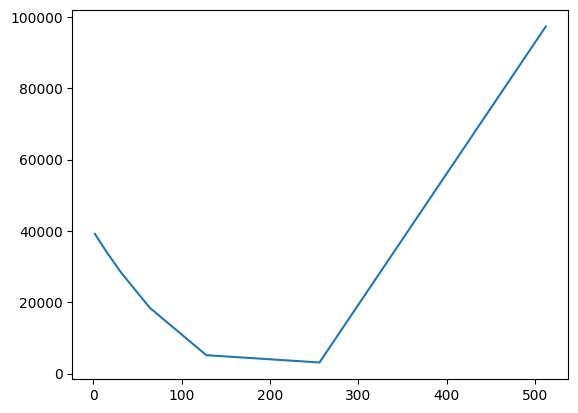

In [113]:
cross_val_isvt(ratings_df[:num_users].to_numpy())